## Training a MF Model through User and Movie Embeddings

In [4]:
# Setup. Import libraries and load dataframes for Movielens data.
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
from keras.models import model_from_json, load_model
import os
import random
import time

# Set random seeds for reproducibility
np.random.seed(1); 
random.seed(1) 

Using TensorFlow backend.


In [5]:
#actual path
fileDir = os.path.dirname(os.path.realpath('__file__'))
#correct path
rating_file = os.path.join(fileDir, '../processed_data/ratings_4std.csv')
# loading ratings data
ratings_df = pd.read_csv(rating_file)

In [6]:
## Global Average Ratings across All Users
av_rating = np.mean(ratings_df.rating)
print("Average Rating across all users {0:.03f}".format(av_rating))

## Center around Global Mean ['y_g']
ratings_df['y_g'] = ratings_df.rating - av_rating


movie_file = os.path.join(fileDir, '../processed_data/movies_preprocessed.csv')
## Combining the Movies Title as a Special Column
movies_df = pd.read_csv(movie_file, usecols=['movieId', 'title'])

df = ratings_df.merge(movies_df, on='movieId').sort_values(by='userId')
df = df.sample(frac=1, random_state=1) # Shuffle

df.sample( 5, random_state = 1 )

Average Rating across all users 3.661


,userId,movieId,rating,y,y_g,title
6484276,95142,1378,3.0,-0.530417,-0.66091,Hamlet
8013101,228054,23741,5.0,1.469583,1.33909,Edge of Tomorrow
6594724,85511,24,3.0,-0.530417,-0.66091,Leaving Las Vegas
7375532,171336,3112,4.0,0.469583,0.33909,Papillon
15230118,239762,19062,5.0,1.469583,1.33909,Safe


In [7]:
n_movies = len(df.movieId.unique())
n_users = len(df.userId.unique())

print("{1:,} distinct users rated {0:,} different movies (total ratings = {2:,})"
      .format(n_movies, n_users, len(df)))

265,726 distinct users rated 25,675 different movies (total ratings = 15,394,772)


In [27]:
movie_embedding_size = user_embedding_size = 32

# Each instance consists of two inputs: a single user id, and a single movie id
user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)

dotted = keras.layers.Dot(2)([user_embedded, movie_embedded])
out = keras.layers.Flatten()(dotted)

model = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
model.compile(
    tf.optimizers.Adam(0.001),
    loss='MSE',
    metrics=['MAE'],
)
model.summary(line_length=88)

Model: "model_6"
________________________________________________________________________________________
Layer (type)                 Output Shape       Param #   Connected to                  
user_id (InputLayer)         (None, 1)          0                                       
________________________________________________________________________________________
movie_id (InputLayer)        (None, 1)          0                                       
________________________________________________________________________________________
user_embedding (Embedding)   (None, 1, 32)      9063328   user_id[0][0]                 
________________________________________________________________________________________
movie_embedding (Embedding)  (None, 1, 32)      1715744   movie_id[0][0]                
________________________________________________________________________________________
dot_6 (Dot)                  (None, 1, 1)       0         user_embedding[0][0]          
    

In [28]:
history = model.fit(
    [df.userId, df.movieId],
    df.y_g,
    batch_size=5000,
    epochs=20,
    validation_split=.1,
);

Train on 16720356 samples, validate on 1857818 samples
Epoch 1/20
16720356/16720356 [==============================] - 248s 15us/step - loss: 0.9104 - MAE: 0.7355 - val_loss: 0.7637 - val_MAE: 0.6628
Epoch 2/20
16720356/16720356 [==============================] - 247s 15us/step - loss: 0.6937 - MAE: 0.6297 - val_loss: 0.7022 - val_MAE: 0.6338
Epoch 3/20
16720356/16720356 [==============================] - 291s 17us/step - loss: 0.6091 - MAE: 0.5877 - val_loss: 0.6799 - val_MAE: 0.6228
Epoch 4/20
16720356/16720356 [==============================] - 291s 17us/step - loss: 0.5452 - MAE: 0.5537 - val_loss: 0.6784 - val_MAE: 0.6219
Epoch 5/20
16720356/16720356 [==============================] - 372s 22us/step - loss: 0.4977 - MAE: 0.5271 - val_loss: 0.6879 - val_MAE: 0.6261
Epoch 6/20
16720356/16720356 [==============================] - 429s 26us/step - loss: 0.4648 - MAE: 0.5078 - val_loss: 0.7009 - val_MAE: 0.6320
Epoch 7/20
16720356/16720356 [==============================] - 396s 24us/s

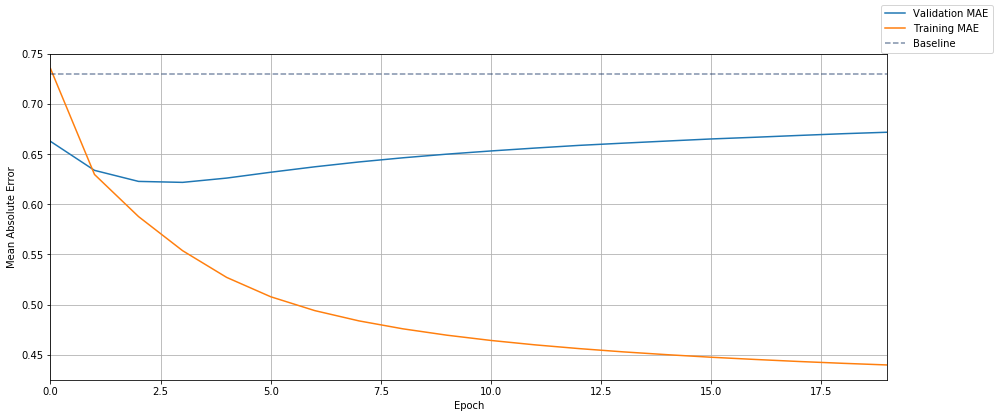

In [29]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(history.epoch, history.history['val_MAE'], label='Validation MAE')
ax.plot(history.epoch, history.history['MAE'], label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=history.epoch[-1])
baseline_mae = 0.73
ax.axhline(baseline_mae, ls='--', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend();
plt.show()

In [30]:
model.save('preprocessed_model_32_20epoch.h5')

/Users/kelvin/opt/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


## Reviews Max 300 per Person

In [33]:
# Setup. Import libraries and load dataframes for Movielens data.
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
from keras.models import model_from_json, load_model
import os
import random
import time

# Set random seeds for reproducibility
np.random.seed(1); 
random.seed(1) 

In [34]:
# loading ratings data
# ratings_df = pd.read_csv('ratings_preprocessed_300reviewsmax.csv')

In [37]:
# movies = pd.read_csv('movies_preprocessed.csv')

In [39]:
## Global Average Ratings across All Users
av_rating = np.mean(ratings_df.rating)
print("Average Rating across all users {0:.03f}".format(av_rating))

## Center around Global Mean ['y_g']
ratings_df['y_g'] = ratings_df.rating - av_rating

## Combining the Movies Title as a Special Column
movies_df = pd.read_csv(os.path.join('movies_preprocessed.csv'), usecols=['movieId', 'title'])

df = ratings_df.merge(movies_df, on='movieId').sort_values(by='userId')
df = df.sample(frac=1, random_state=1) # Shuffle

df.sample( 5, random_state = 1 )

Average Rating across all users 3.671


,userId,movieId,rating,y,y_g,title
6866262,40035,1182,5.0,1.469583,1.32897,Apocalypse Now
7130132,207831,26883,4.5,0.969583,0.82897,Doctor Strange
4162256,123838,1243,4.0,0.469583,0.32897,Fried Green Tomatoes
3871155,81880,340,3.0,-0.530417,-0.67103,Ace Ventura: Pet Detective
2786750,189120,1343,4.0,0.469583,0.32897,Star Trek II: The Wrath of Khan


In [40]:
n_movies = len(df.movieId.unique())
n_users = len(df.userId.unique())

print("{1:,} distinct users rated {0:,} different movies (total ratings = {2:,})"
      .format(n_movies, n_users, len(df)))

261,115 distinct users rated 25,019 different movies (total ratings = 13,916,602)


In [41]:
movie_embedding_size = user_embedding_size = 32

# Each instance consists of two inputs: a single user id, and a single movie id
user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)

dotted = keras.layers.Dot(2)([user_embedded, movie_embedded])
out = keras.layers.Flatten()(dotted)

model = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
model.compile(
    tf.optimizers.Adam(0.001),
    loss='MSE',
    metrics=['MAE'],
)
model.summary(line_length=88)

Model: "model_7"
________________________________________________________________________________________
Layer (type)                 Output Shape       Param #   Connected to                  
user_id (InputLayer)         (None, 1)          0                                       
________________________________________________________________________________________
movie_id (InputLayer)        (None, 1)          0                                       
________________________________________________________________________________________
user_embedding (Embedding)   (None, 1, 32)      9063328   user_id[0][0]                 
________________________________________________________________________________________
movie_embedding (Embedding)  (None, 1, 32)      1715744   movie_id[0][0]                
________________________________________________________________________________________
dot_7 (Dot)                  (None, 1, 1)       0         user_embedding[0][0]          
    

In [42]:
history = model.fit(
    [df.userId, df.movieId],
    df.y_g,
    batch_size=5000,
    epochs=5,
    validation_split=.1,
);

Train on 12524941 samples, validate on 1391661 samples
Epoch 1/5
12524941/12524941 [==============================] - 238s 19us/step - loss: 0.9731 - MAE: 0.7644 - val_loss: 0.8164 - val_MAE: 0.6854
Epoch 2/5
12524941/12524941 [==============================] - 247s 20us/step - loss: 0.7301 - MAE: 0.6457 - val_loss: 0.7424 - val_MAE: 0.6525
Epoch 3/5
12524941/12524941 [==============================] - 268s 21us/step - loss: 0.6311 - MAE: 0.5976 - val_loss: 0.7182 - val_MAE: 0.6408
Epoch 4/5
12524941/12524941 [==============================] - 296s 24us/step - loss: 0.5549 - MAE: 0.5575 - val_loss: 0.7176 - val_MAE: 0.6403
Epoch 5/5
12524941/12524941 [==============================] - 254s 20us/step - loss: 0.4960 - MAE: 0.5245 - val_loss: 0.7304 - val_MAE: 0.6459


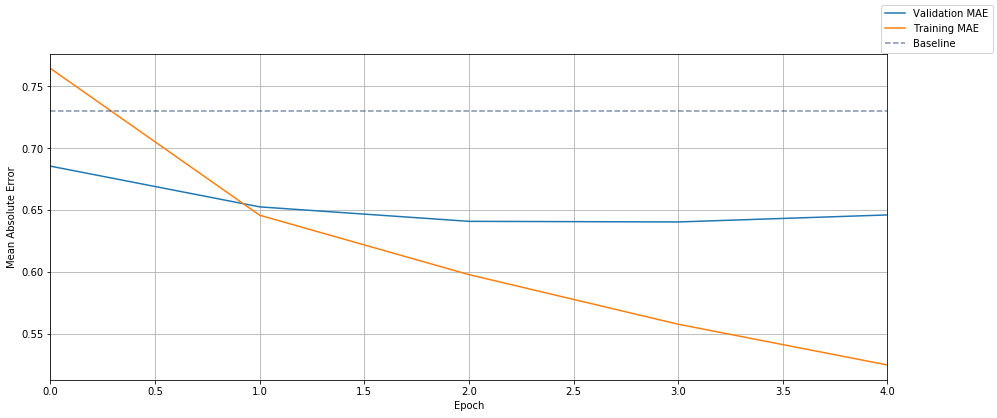

In [43]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(history.epoch, history.history['val_MAE'], label='Validation MAE')
ax.plot(history.epoch, history.history['MAE'], label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=history.epoch[-1])
baseline_mae = 0.73
ax.axhline(baseline_mae, ls='--', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend();
plt.show()

In [44]:
model.save('model_300maxreviews.h5')

/Users/kelvin/opt/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '
